In [40]:
import pandas as pd
import seaborn as sns
import xgboost as xgb
import calendar
from sqlalchemy import create_engine
from datetime import datetime
from datetime import timedelta
from sklearn import model_selection
from matplotlib import pyplot as plt
%matplotlib inline

# scikit-learn              1.0.2
from sklearn.model_selection import GridSearchCV

In [41]:
engine = create_engine("mysql+pymysql://{}:{}@{}:{}/{}".format('root', '123456', 'localhost', '3306', 'erp_jd_dwd')) 
engine1 = create_engine("mysql+pymysql://{}:{}@{}:{}/{}".format('root', '123456', 'localhost', '3306', 'erp_jd_dws')) 
engine2 = create_engine("mysql+pymysql://{}:{}@{}:{}/{}".format('root', '123456', 'localhost', '3306', 'bi'))
conn = create_engine("mssql+pymssql://{}:{}@{}:{}/{}".format('sa', '123456', '10.242.21.1', '1433', 'bi'))

df_sales = pd.read_sql_query('select * from erp_jd_dwd_dim_saleshipping;', engine)
df_launchtime = pd.read_sql_query('select * from erp_jd_dws_launchtime;', engine1)

df_pro = pd.read_excel(r'C:\Users\liujin02\Desktop\采购报表\采购报表.xlsx')
df_holiday = pd.read_excel(r'C:\Users\liujin02\Desktop\BI建设\API_BI\本地数据源\vacation.xlsx')

df_holiday['date'] = pd.to_datetime(df_holiday['date'],format='%Y-%m-%d')

df_sales = df_sales[~df_sales['kehumc'].isin(['杭州游卡文化创意有限公司','杭州泳淳网络技术有限公司','杭州迷思文化创意有限公司'])]
listPro = df_pro['产品名称'].to_list()
df_sales = df_sales[df_sales['wuliaomc'].isin(listPro)]

In [42]:
df_sales = df_sales[df_sales['bumen']=='电商平台部']

In [43]:
# 将存在其它字符表示分类的特征转化为数字
def dict_(df,name):

    df_wl = df[name].drop_duplicates().reset_index(drop=True)
    df_wl1 = df_wl.reset_index(drop=True).reset_index()
    df_wl1['index'] = df_wl1['index']+1 # 索引+1，后续填充0时防止和有序变量弄混
    return dict(zip(df_wl1[name],df_wl1['index'])), df_wl


# 创建日期辅助表
def create_assist_date(datestart,dateend):
    date_list = []
    date_list.append(datestart)
    while datestart < dateend:
        datestart+=timedelta(days=+1)
        date_list.append(datestart)
    return pd.DataFrame(date_list,columns=['riqi'])


def change(df2):
    #将时间特征进行拆分和转化
    df2['year']=df2['riqi'].apply(lambda x:x.year)
    df2['month']=df2['riqi'].apply(lambda x:x.month)
    df2['day']=df2['riqi'].apply(lambda x:x.day)
        
    df2['IsVacation'] = df2.apply(lambda x:1 if x['month']==1 or x['month']==2 or x['month']==7 or x['month']==8 else 0 ,axis=1)
    # 'IsVacation' ： 0：非假期，1：寒暑假

    df2['weekday'] = df2.apply(lambda x: datetime.weekday(x['riqi'])+1,axis=1)
    # 'weekday' ： 返回中国式星期

    df2 = pd.merge(df2,df_holiday,left_on=['riqi'],right_on=['date'],how='left')
    df2['status'].fillna(0,inplace=True)
    for i in range(len(df2)):
        if df2['status'][i] == 0 and (df2['weekday'][i]==6 or df2['weekday'][i]==7):
            df2['status'][i] = 1
        elif df2['status'][i] != 0:
            continue
        else:
            df2['status'][i] = 2
    # 'status' ： 1：节假日，2：工作日
    df2.drop(['date'],axis=1,inplace=True)
    df2['status'].replace(2,0,inplace=True)
    return df2


def getDictKey(mydict,value,word):
    try:
        return [k for k,v in mydict.items() if value == v][0]
    except:
        return word

特征清洗

In [44]:
df_sales['hanshuidj_min'] = df_sales['hanshuidj'] 
df_sales['hanshuidj_med'] = df_sales['hanshuidj'] 
df_sales['hanshuidj_max'] = df_sales['hanshuidj'] 	
df_sale = df_sales.groupby(['wuliaomc','riqi'],as_index = False).agg({'shifasl':'sum','hanshuidj_min':'min','hanshuidj_med':'median','hanshuidj_max':'max','beizhu':'count'})
# 部门
a = df_sales.groupby(['wuliaomc','riqi','kehumc']).agg({'shifasl':'sum'}).unstack()
a.columns = a.columns.droplevel()
a = a[['yokagames玩具旗舰店', '三国杀得物店', '三国杀旗舰店','三国杀游卡专卖店（京东）','京东-剧本杀旗舰店',\
       '剧本杀旗舰店','北京京东世纪贸易有限公司','周边商城','小红书-YOKAGAMES','拼多多-YOKAGAMES游卡专卖店',\
        '桌游志旗舰店','游卡桌游文化店','真相档案旗舰店']].reset_index(drop=True)
df = pd.concat([df_sale,a],axis=1)
# 插入日期
listFz = []
dateMax = df['riqi'].max()
for i in dict_(df,'wuliaomc')[1]:
    dfMid = df[df['wuliaomc']==i]
    dateMin = dfMid['riqi'].min()
    dateFz = create_assist_date(dateMin,dateMax)
    dfMid = pd.merge(dateFz,dfMid,on =['riqi'],how = 'left')
    dfMid['shifasl'].fillna(0,inplace=True)	
    dfMid.fillna(method='ffill',inplace=True)	
    listFz.append(dfMid)
df = pd.concat(listFz,ignore_index=True)

df = change(df)
df['weeknum'] = df['riqi'].map(lambda x: int(datetime.strptime(str(x)[:10],'%Y-%m-%d').strftime('%W'))+1)
df['month'] = df['riqi'].map(lambda x:x.month)

df['y_m'] = df['year']*100 + df['month']
df['y_w'] = df['year']*100 + df['weeknum']
# 辅助日期表，计算每月假日天数
dff = change(create_assist_date(df['riqi'].min(),df['riqi'].max()))
dff['weeknum'] = dff['riqi'].map(lambda x: int(datetime.strptime(str(x)[:10],'%Y-%m-%d').strftime('%W'))+1)

dff['y_m'] = dff['year']*100 + dff['month']
dff['y_w'] = dff['year']*100 + dff['weeknum']
dff['status_w'] = dff['status'].map(lambda x:1 if x == 0 else 0)
dffm = dff.groupby('y_m',as_index=False).agg({'status':'sum','status_w':'sum'})
dffw = dff.groupby('y_w',as_index=False).agg({'status':'sum','status_w':'sum'})

dfm = df.groupby(['wuliaomc','y_m'],as_index = False).agg({'shifasl':'sum','hanshuidj_min':'min','hanshuidj_med':'median','hanshuidj_max':'max','beizhu':'count',\
                                                    'yokagames玩具旗舰店':'sum', '三国杀得物店':'sum', '三国杀旗舰店':'sum','三国杀游卡专卖店（京东）':'sum','京东-剧本杀旗舰店':'sum',\
                                                    '剧本杀旗舰店':'sum','北京京东世纪贸易有限公司':'sum','周边商城':'sum','小红书-YOKAGAMES':'sum','拼多多-YOKAGAMES游卡专卖店':'sum',\
                                                    '桌游志旗舰店':'sum','游卡桌游文化店':'sum','真相档案旗舰店':'sum',\
                                                    'year':'min','month':'min','IsVacation':'min'})
dfw = df.groupby(['wuliaomc','y_w'],as_index = False).agg({'shifasl':'sum','hanshuidj_min':'min','hanshuidj_med':'median','hanshuidj_max':'max','beizhu':'count',\
                                                    'yokagames玩具旗舰店':'sum', '三国杀得物店':'sum', '三国杀旗舰店':'sum','三国杀游卡专卖店（京东）':'sum','京东-剧本杀旗舰店':'sum',\
                                                    '剧本杀旗舰店':'sum','北京京东世纪贸易有限公司':'sum','周边商城':'sum','小红书-YOKAGAMES':'sum','拼多多-YOKAGAMES游卡专卖店':'sum',\
                                                    '桌游志旗舰店':'sum','游卡桌游文化店':'sum','真相档案旗舰店':'sum',\
                                                    'year':'min','month':'min','IsVacation':'min','weeknum':'min'})                       
dfmr = pd.merge(dfm,dffm,on=['y_m'],how='left')
dfwr = pd.merge(dfw,dffw,on=['y_w'],how='left')
# 计算每月天数
listDay = []
for i in range(len(dfmr)):
    listDay.append(calendar.monthrange(dfmr['year'][i],dfmr['month'][i])[1])
dfmr['day'] = pd.DataFrame(listDay)

list_d = ['yokagames玩具旗舰店', '三国杀得物店', '三国杀旗舰店','三国杀游卡专卖店（京东）','京东-剧本杀旗舰店',\
       '剧本杀旗舰店','北京京东世纪贸易有限公司','周边商城','小红书-YOKAGAMES','拼多多-YOKAGAMES游卡专卖店',\
        '桌游志旗舰店','游卡桌游文化店','真相档案旗舰店']
for i in list_d:
    dfmr[i] = dfmr[i].map(lambda x:1 if x>0 else 0)
    dfwr[i] = dfwr[i].map(lambda x:1 if x>0 else 0)

# 返回当下的年月，后面原表剔除此值方便验证和预测
y_m = datetime.now().year*100+datetime.now().month
y_w = dateMax.year*100 + int(dateMax.strftime('%W'))+1
dfmr = dfmr[dfmr['y_m'] != y_m]
dfwr = dfwr[dfwr['y_w'] != y_w]

z = df_sales[['wuliaofzmc','wuliaomc']].drop_duplicates()
def funcA(dfmr,name):
    
    dfmr = pd.merge(dfmr,z,on=['wuliaomc'],how='left')
    dfmr.sort_values(by=[name],inplace=True)
    dfmr.reset_index(inplace=True)
    # 分类的特征转化为数字
    dict_wl = dict_(dfmr,'wuliaomc')[0]
    dict_fz = dict_(dfmr,'wuliaofzmc')[0]
    # print(dict_fz)
    dfmr['wuliaomc'].replace(dict_wl,inplace=True)
    dfmr['wuliaofzmc'].replace(dict_fz,inplace=True)
    return dfmr

C:\Users\liujin02\AppData\Local\Temp/ipykernel_22860/1427969070.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['status'][i] = 2
C:\Users\liujin02\AppData\Local\Temp/ipykernel_22860/1427969070.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['status'][i] = 1


In [45]:
# 赋表，选择月预测或周预测修改此处
dfr = dfwr.copy()
name = 'y_w'
dfr = funcA(dfr,'y_w')

趋势查看

D:\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 29609 (\N{CJK UNIFIED IDEOGRAPH-73A9}) missing from current font.
  fig.canvas.draw()
D:\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 20855 (\N{CJK UNIFIED IDEOGRAPH-5177}) missing from current font.
  fig.canvas.draw()
D:\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 26071 (\N{CJK UNIFIED IDEOGRAPH-65D7}) missing from current font.
  fig.canvas.draw()
D:\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 33328 (\N{CJK UNIFIED IDEOGRAPH-8230}) missing from current font.
  fig.canvas.draw()
D:\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 24215 (\N{CJK UNIFIED IDEOGRAPH-5E97}) missing from current font.
  fig.canvas.draw()
D:\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGRAPH-4E09}) missing from current font.
  fig.canvas.draw()
D:\lib\site-packages\seaborn\utils.py:95: UserWarning: Glyph 22269 (\N{CJK UNIFIED IDEOGRAPH-56FD}) missing from curre

<AxesSubplot:>

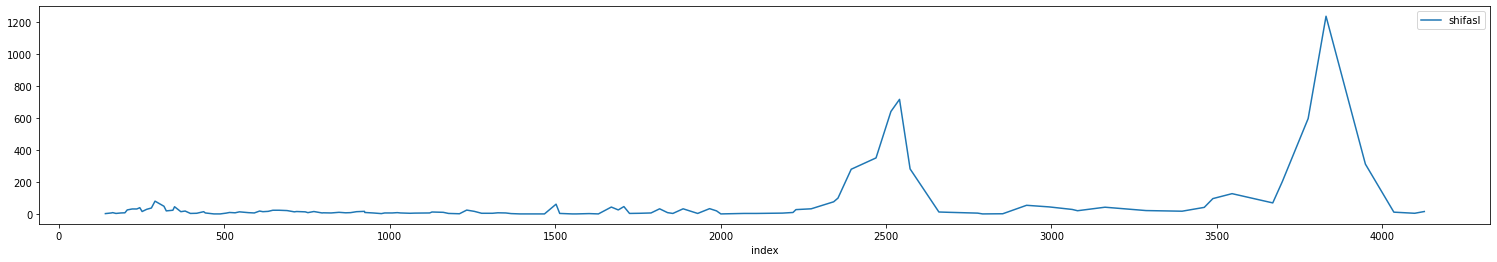

D:\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 29609 (\N{CJK UNIFIED IDEOGRAPH-73A9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 20855 (\N{CJK UNIFIED IDEOGRAPH-5177}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 26071 (\N{CJK UNIFIED IDEOGRAPH-65D7}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 33328 (\N{CJK UNIFIED IDEOGRAPH-8230}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 24215 (\N{CJK UNIFIED IDEOGRAPH-5E97}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 19977 (\N{CJK UNIFIED IDEOGR

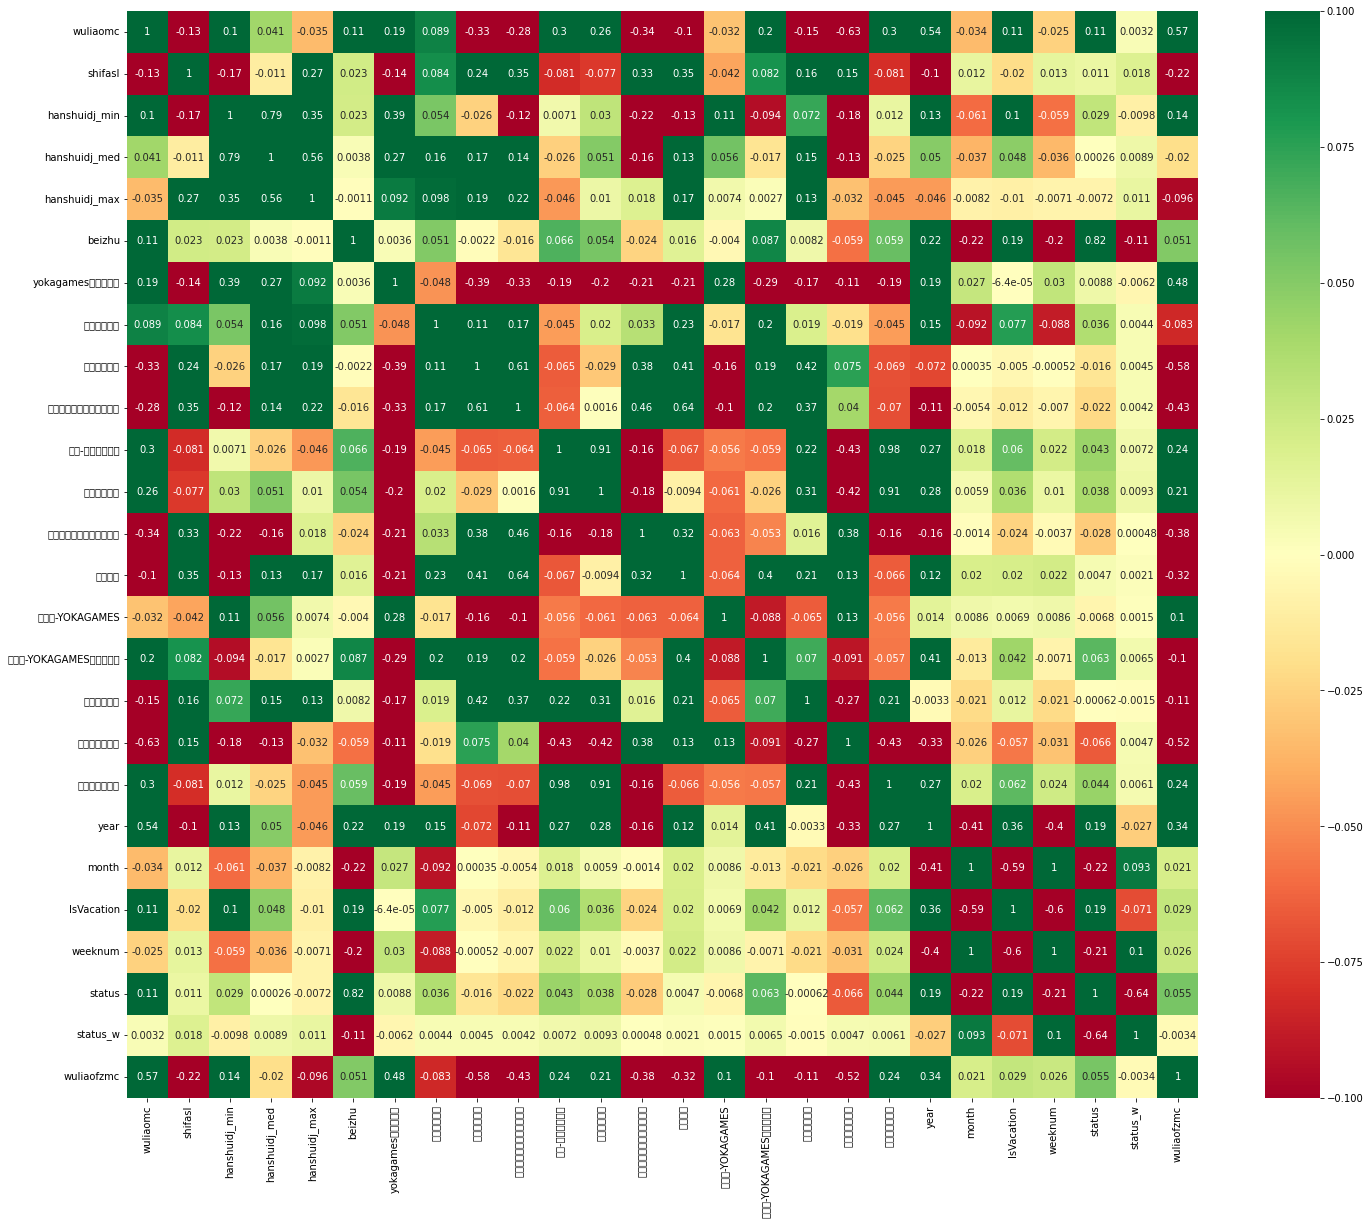

In [46]:
dfr.drop(['index'],axis=1,inplace=True)
dfr.reset_index(inplace=True)
dfr.loc[dfr['wuliaomc']==10,['index','shifasl']].plot(x='index',y='shifasl',figsize=(26,4))

#删掉训练和测试数据集中不需要的特征
df_train = dfr.drop([name,'index'],axis=1)

plt.subplots(figsize=(24,20))
sns.heatmap(df_train.corr(),cmap='RdYlGn',annot=True,vmin=-0.1,vmax=0.1,center=0)

训练集划分

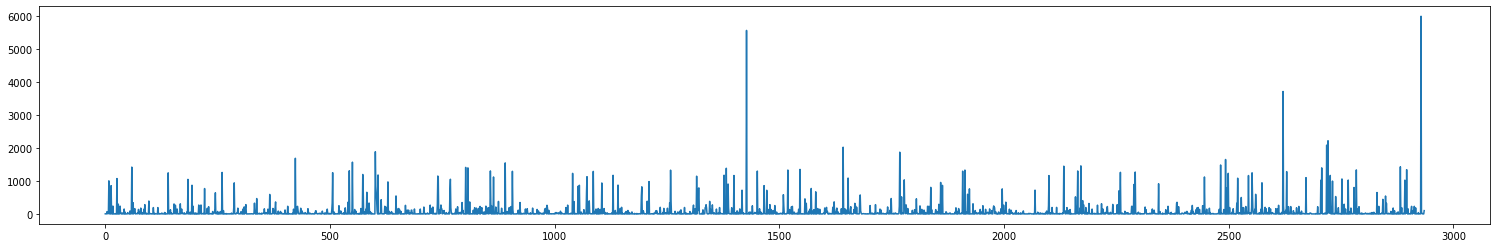

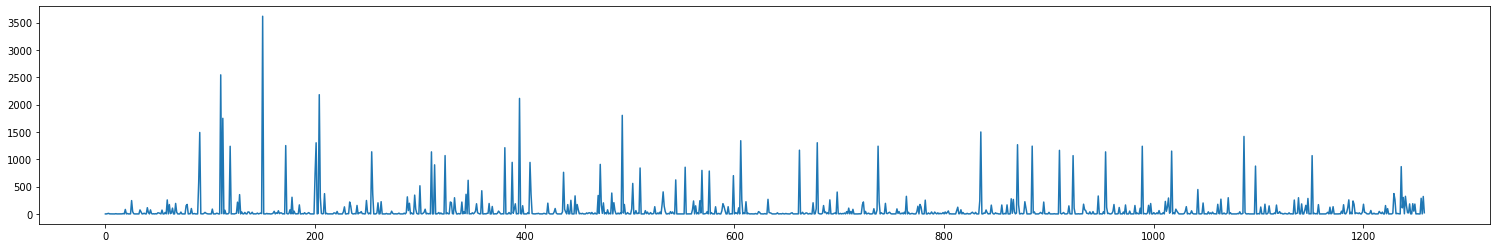

In [55]:
# 设置数据集，切分数据，固定随机种子（random_state）时，同样的代码，得到的训练集数据相同。
x, y = df_train.drop(['shifasl'],axis=1),df_train['shifasl']
Xtrain, Xtest, ytrain, ytest = model_selection.train_test_split( x, y, test_size=0.3, random_state=42)

# 查看分布
pytrain = ytrain.reset_index(drop=True)
plt.figure(figsize=(26,4))   
plt.plot(pytrain.index,pytrain.values)

pytest = ytest.reset_index(drop=True)
plt.figure(figsize=(26,4))   
plt.plot(pytest.index,pytest.values)

模型构建

In [56]:
# 调参
cv_params = {'learning_rate': [0.01,0.02]}
other_params = {'n_estimators': 120, 'max_depth':13, 'min_child_weight': 4, 'gamma': 0.1, 
                'subsample': 0.7, 'colsample_bytree': 0.6, 'reg_alpha': 3, 'reg_lambda': 3, 'learning_rate': 0.02,'seed': 10}
 
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1)
gbm = optimized_GBM.fit(Xtrain, ytrain)
print('参数的最佳取值:{0}'.format(gbm.best_params_))
print('最佳模型得分:{0}'.format(gbm.best_score_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits
参数的最佳取值:{'learning_rate': 0.02}
最佳模型得分:0.5650754613910077


Mean Ratio of predition and real sales data is nan:store all
Mean Ratio of predition and real sales data is inf:wuliaomc 1
Mean Ratio of predition and real sales data is nan:wuliaomc 2
Mean Ratio of predition and real sales data is inf:wuliaomc 3
Mean Ratio of predition and real sales data is nan:wuliaomc 4
Mean Ratio of predition and real sales data is inf:wuliaomc 5
Mean Ratio of predition and real sales data is nan:wuliaomc 6
Mean Ratio of predition and real sales data is inf:wuliaomc 7
Mean Ratio of predition and real sales data is nan:wuliaomc 8
Mean Ratio of predition and real sales data is nan:wuliaomc 9


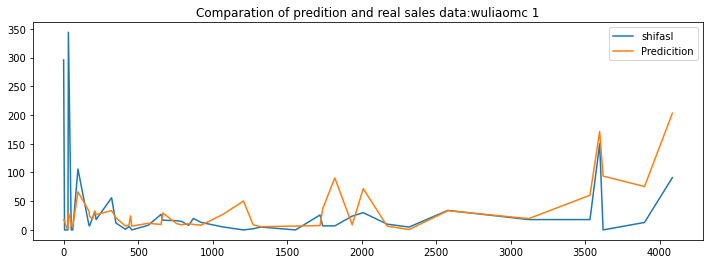

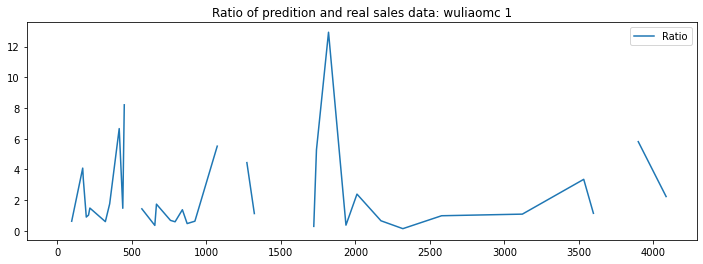

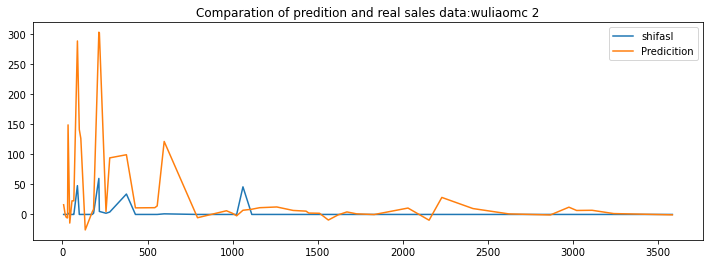

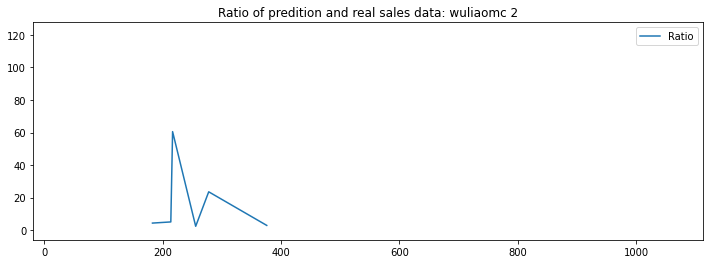

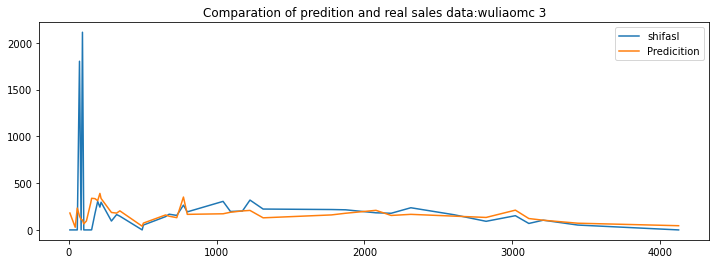

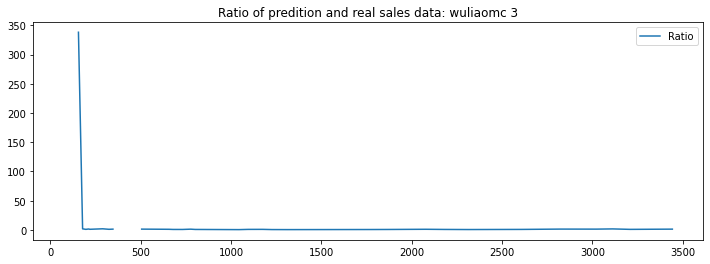

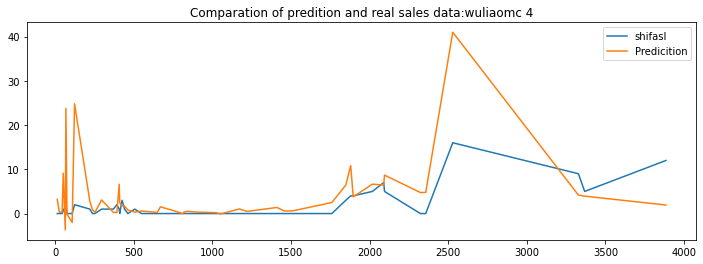

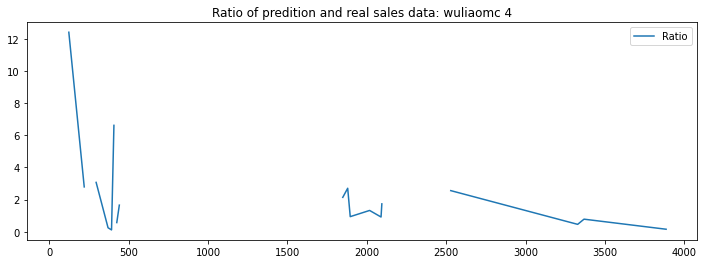

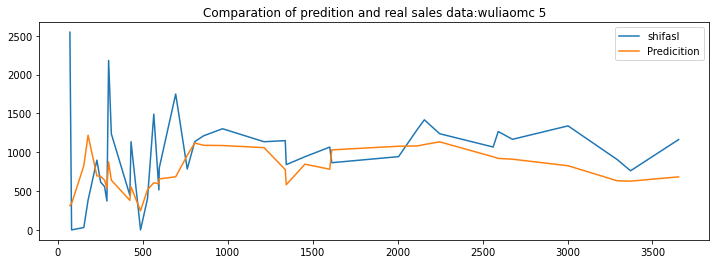

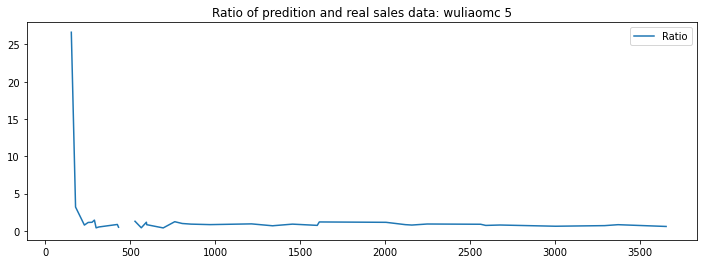

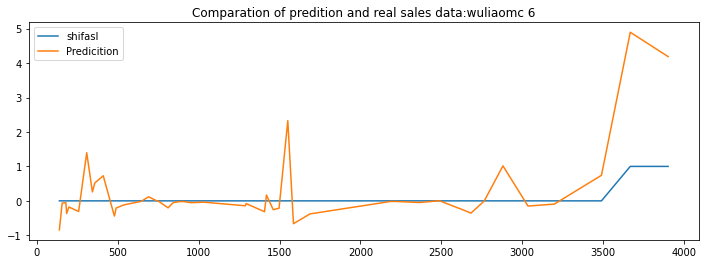

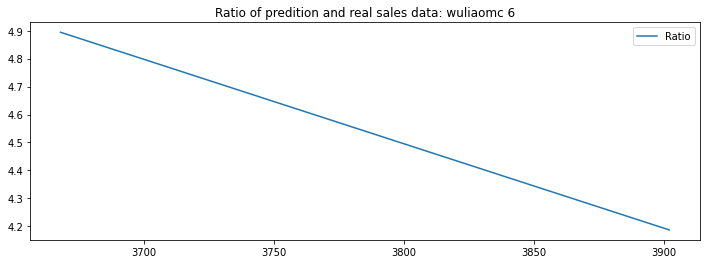

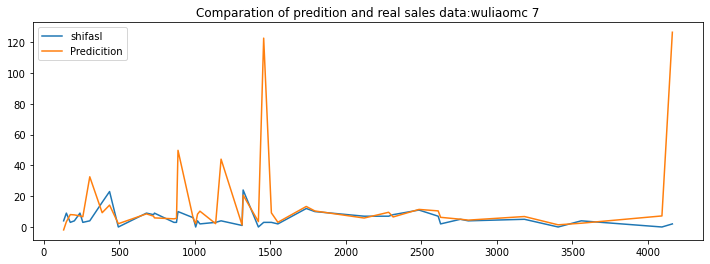

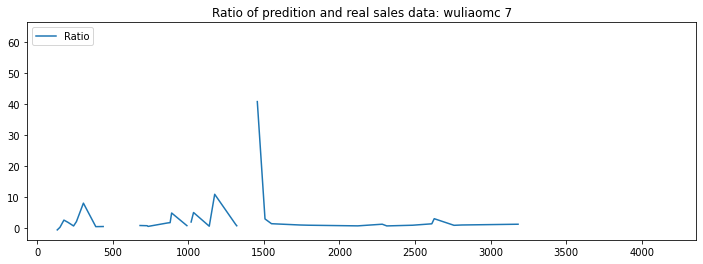

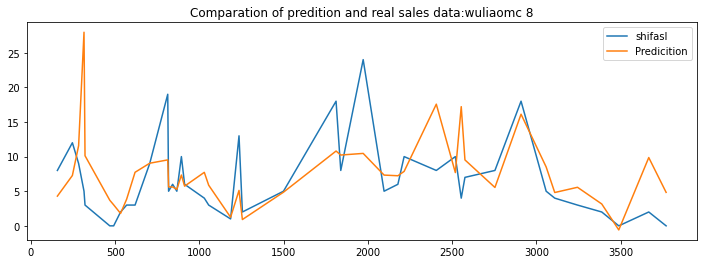

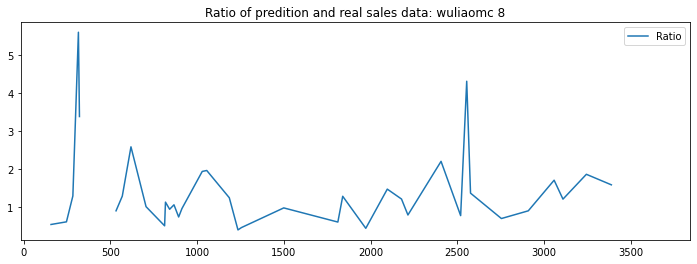

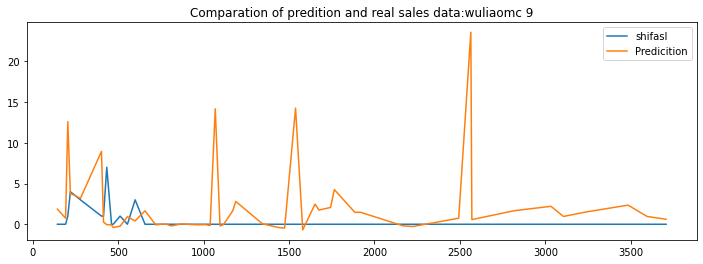

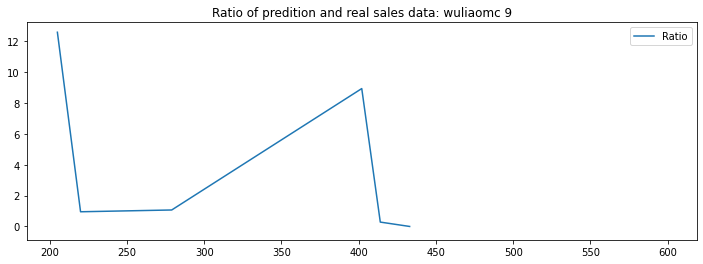

In [57]:
#采用保留数据集进行检测
Xtest.sort_index(inplace=True)
ytest.sort_index(inplace=True)
yhat = gbm.predict(Xtest)
res=pd.DataFrame(data=ytest)
res['Predicition']=yhat
res=pd.merge(Xtest,res,left_index=True,right_index=True)
res['Ratio']=res['Predicition']/res['shifasl']

# 分析保留数据集中任意三个店铺的预测结果
col_1=['shifasl','Predicition']
col_2=['Ratio']
print('Mean Ratio of predition and real sales data is {}:store all'.format(res['Ratio'].mean()))
for i in range(1,10):
    s1=pd.DataFrame(res[res['wuliaomc']==i],columns=col_1)
    s2=pd.DataFrame(res[res['wuliaomc']==i],columns=col_2)
    s1.plot(title='Comparation of predition and real sales data:wuliaomc {}'.format(i),figsize=(12,4))
    s2.plot(title='Ratio of predition and real sales data: wuliaomc {}'.format(i),figsize=(12,4))
    print('Mean Ratio of predition and real sales data is {}:wuliaomc {}'.format(s2['Ratio'].mean(),i))

测试集

In [58]:
# 以数据集的未来一天开始作为预测的第一天，共预测30天
date_start = df_sales['riqi'].max()+timedelta(1)
date_end = df_sales['riqi'].max()+timedelta(30)
df_t = create_assist_date(date_start,date_end)
df_t = change(df_t)
df_t['status_w'] = df_t['status'].map(lambda x:1 if x == 0 else 0)
df_t['weeknum'] = df_t['riqi'].map(lambda x: int(datetime.strptime(str(x)[:10],'%Y-%m-%d').strftime('%W'))+1)
df_t['y_w'] = df_t['year']*100 + df_t['weeknum']

# 增加类别项
df_t['wuliaomc'] = pd.Series() 
list_t = []
for i in dict_(dfmr,'wuliaomc')[1]:
    list_t.append(df_t.fillna(i))
df_test = pd.concat(list_t, sort=False)
df_test = df_test.groupby(['y_w','wuliaomc'],as_index=False).agg({'year':'max','month':'max','IsVacation':'max','status':'sum','status_w':'sum','weeknum':'max'})

# 原特征提取
dfDepart = dfmr.groupby('wuliaomc',as_index=False).agg({'yokagames玩具旗舰店':'max', '三国杀得物店':'max', '三国杀旗舰店':'max','三国杀游卡专卖店（京东）':'max','京东-剧本杀旗舰店':'max',\
                                                        '剧本杀旗舰店':'max','北京京东世纪贸易有限公司':'max','周边商城':'max','小红书-YOKAGAMES':'max','拼多多-YOKAGAMES游卡专卖店':'max',\
                                                        '桌游志旗舰店':'max','游卡桌游文化店':'max','真相档案旗舰店':'max'})
dfIndex = dfmr.reset_index()
dfIndex1 = dfIndex.groupby('wuliaomc',as_index=False).agg({'y_m':'max','index':'max'})
listIndex = dfIndex1['index'].to_list()
dfIndex2 = dfIndex[dfIndex['index'].isin(listIndex)][['hanshuidj_min','hanshuidj_med','hanshuidj_max']]
dfIndex2.reset_index(drop=True,inplace=True)
dfConcat = pd.concat([dfDepart,dfIndex2],axis=1)

df_test = pd.merge(df_test,dfConcat,on=['wuliaomc'],how = 'left')
df_test['wuliaomc'].replace(dict_(dfmr,'wuliaomc')[0],inplace=True) # 特征替换
df_test.drop(['y_w'],axis=1,inplace=True)
df_test['beizhu'] = 0
z1 = dfr[['wuliaofzmc','wuliaomc']].drop_duplicates()
df_test = pd.merge(df_test,z1,on=['wuliaomc'],how='left')

# 计算每月天数
listDay1 = []
for i in range(len(df_test)):
    listDay1.append(calendar.monthrange(df_test['year'][i],df_test['month'][i])[1])
df_test['day'] = pd.DataFrame(listDay1)

df_test = df_test[x.columns] # 列标签顺序调整

# 测试集预测
df_test['Predicition'] = gbm.predict(df_test)
res['wuliaomc'] = res['wuliaomc'].map(lambda x:getDictKey(dict_(dfmr,'wuliaomc')[0],x,0))
df_test['wuliaomc'] = df_test['wuliaomc'].map(lambda x:getDictKey(dict_(dfmr,'wuliaomc')[0],x,0))


C:\Users\liujin02\AppData\Local\Temp/ipykernel_22860/1427969070.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['status'][i] = 2
C:\Users\liujin02\AppData\Local\Temp/ipykernel_22860/1427969070.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['status'][i] = 1
C:\Users\liujin02\AppData\Local\Temp/ipykernel_22860/2934456037.py:11: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  df_t['wuliaomc'] = pd.Series()


In [59]:
from datetime import datetime
# 年度系数
df_xs = df_sales.groupby(['month','year'])['shifasl'].sum().unstack()
df_mxs = df_xs.div(df_xs.iloc[0:1].values, axis=1)
df_yxs = df_xs.div(df_xs['2019'].values, axis=0)

# 增加近1，3，6月均销量
df180 = df_sales[df_sales['riqi'] >= datetime.now()-timedelta(180)]
df90 = df_sales[df_sales['riqi'] >= datetime.now()-timedelta(90)]
df30 = df_sales[df_sales['riqi'] >= datetime.now()-timedelta(30)]
df180 = df180.groupby(['wuliaomc'],as_index = False).agg({'shifasl':'sum'})
df90 = df90.groupby(['wuliaomc'],as_index = False).agg({'shifasl':'sum'})
df30 = df30.groupby(['wuliaomc'],as_index = False).agg({'shifasl':'sum'})
df90['shifasl'] = round(df90['shifasl']/3,0)
df180['shifasl'] = round(df180['shifasl']/6,0)
df30.rename(columns={'shifasl':'30days_mean'},inplace=True)
df90.rename(columns={'shifasl':'90days_mean'},inplace=True)
df180.rename(columns={'shifasl':'180days_mean'},inplace=True)

df_test_m = df_test.groupby(['wuliaomc'],as_index=False)['Predicition'].sum()
df_test_m = pd.merge(df_test_m,df30,on=['wuliaomc'],how='left')
df_test_m = pd.merge(df_test_m,df90,on=['wuliaomc'],how='left')
df_test_m = pd.merge(df_test_m,df180,on=['wuliaomc'],how='left')
df_test_m.fillna(0,inplace=True)
# 根据销量进行预测的条件约束
df_test_m['Predicition'] = df_test_m['Predicition'].map(lambda x: round(x,0) if x>0 else 0)
for i in range(len(df_test_m)):
    if df_test_m['90days_mean'][i] == 0:
        df_test_m['Predicition'][i] = 0
for i in range(len(df_test_m)):
    if df_test_m['Predicition'][i] > 1.25*df_test_m['180days_mean'][i] and df_test_m['Predicition'][i] > 1.25*df_test_m['90days_mean'][i] and df_test_m['Predicition'][i] > 1.25*df_test_m['30days_mean'][i]:
        df_test_m['Predicition'][i] = round(0.75*max(df_test_m['30days_mean'][i],df_test_m['90days_mean'][i],df_test_m['180days_mean'][i]),0)
    elif df_test_m['Predicition'][i] < 0.75*df_test_m['180days_mean'][i] and df_test_m['Predicition'][i] < 0.75*df_test_m['90days_mean'][i] and df_test_m['Predicition'][i] < 0.75*df_test_m['30days_mean'][i]:
        df_test_m['Predicition'][i] = round(1.25*min(df_test_m['30days_mean'][i],df_test_m['90days_mean'][i],df_test_m['180days_mean'][i]),0)

C:\Users\liujin02\AppData\Local\Temp/ipykernel_22860/1557448024.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_m['Predicition'][i] = 0
C:\Users\liujin02\AppData\Local\Temp/ipykernel_22860/1557448024.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_m['Predicition'][i] = round(0.75*max(df_test_m['30days_mean'][i],df_test_m['90days_mean'][i],df_test_m['180days_mean'][i]),0)
C:\Users\liujin02\AppData\Local\Temp/ipykernel_22860/1557448024.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org

In [60]:
# *****************************************写入数据库*******************************************#
df_test_m.to_sql('bi_forecastsales_wlds', engine2, schema='bi', if_exists='replace', index=False)
engine.dispose()
engine1.dispose()
engine2.dispose()

df_test_m.to_sql(name='bi_forecastsales_wlds', con=conn, if_exists='replace', index=False)
conn.dispose() 


res.to_excel(r'C:\Users\liujin02\Desktop\BI建设\API_BI\forecast_sales\result\val_salesds.xlsx')
df_test.to_excel(r'C:\Users\liujin02\Desktop\BI建设\API_BI\forecast_sales\result\forecast_salesds.xlsx')